In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# Display the first row of data in dictionary format
first_row = session.query(Measure).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1abe4f1ff40>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [10]:
# Display date column in descending order and select first result
latest_date = session.query(Measure.date).\
    order_by(Measure.date.desc()).first()

print(latest_date)


('2017-08-23',)


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
start_date = last_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date >= '2016-08-23').all()    

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp)
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_df = prcp_df.sort_values(by="date")
sorted_df

# grouped_df = prcp_df.groupby("Date").sum().sort_values("Date", ascending=True)


,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


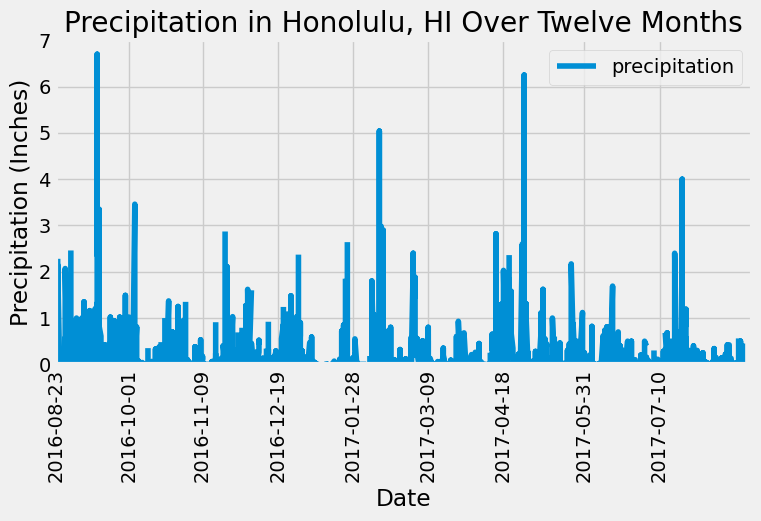

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plot figure, add legend, set xticks, labels, and xlim/ylim
plt.figure(figsize=(8,4))
plt.plot(sorted_df.index, sorted_df['prcp'])
plt.legend(['precipitation'], loc="upper right")
xloc = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19',
        '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31',
        '2017-07-10']
plt.xticks(xloc, rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title("Precipitation in Honolulu, HI Over Twelve Months")
plt.xlim(0,370)
plt.ylim(0,7)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
# Display first row of Station column in dictionary format
first_row2 = session.query(Station).first()
first_row2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1abe504fd30>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [16]:
# Run query to calculate total number of stations
session.query(Station.station).count()

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active = [Station.station, func.count(Measure.station)]
session.query(*active).filter(Station.station == Measure.station).group_by(Station.station).\
    order_by(func.count(Measure.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [func.min(Measure.tobs), func.max(Measure.tobs), func.avg(Measure.tobs)]
session.query(*temps).filter(Measure.station == active[0]).all()

[(53.0, 87.0, 73.09795396419437)]

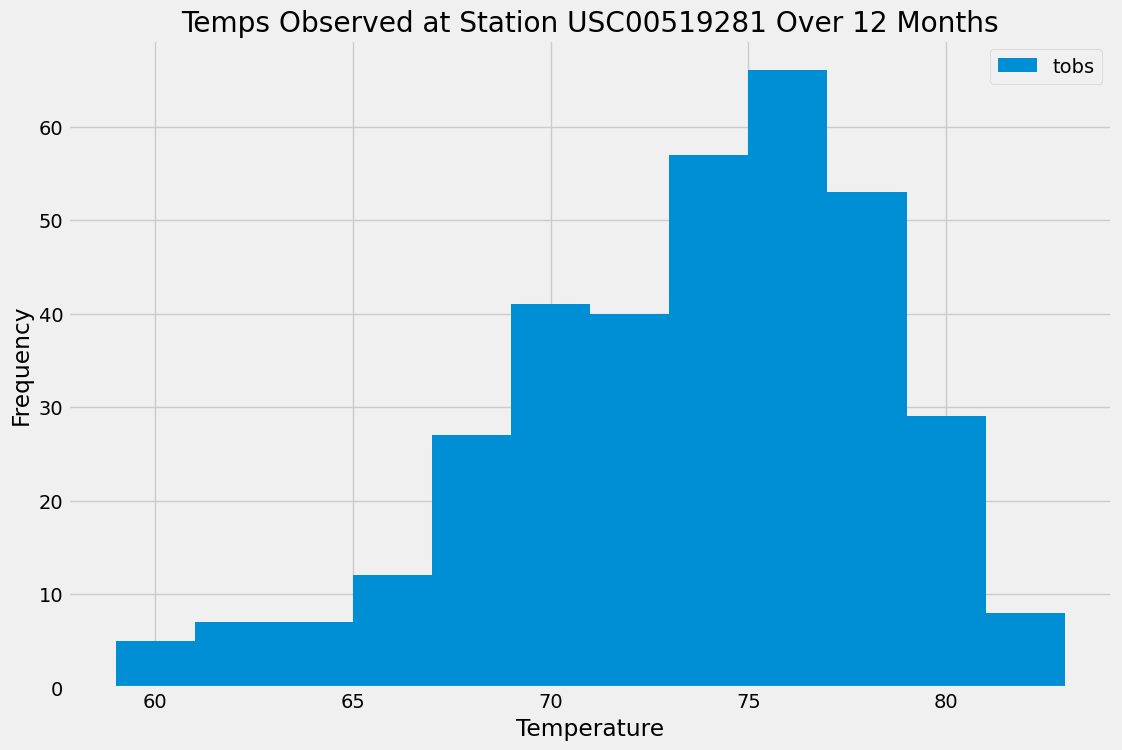

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
active_temps = session.query(Measure.tobs).\
    filter(Measure.date >= '2016-08-23',\
           Measure.station == 'USC00519281').all()

# Plot the results as a histogram
plt.figure(figsize=(12,8))
plt.hist(np.ravel(active_temps), bins=12)
plt.title('Temps Observed at Station USC00519281 Over 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='upper right')
plt.show()

# Close session

In [20]:
# Close Session
session.close()